# Lab 3: Environmental Impact Analysis in the Steel Industry

## Objectives
1. Analyze the relationship between energy consumption and CO2 emissions
2. Identify environmental impact profiles
3. Propose emission reduction strategies

## Structure
1. Data preparation
2. CO2 emissions analysis
3. Clustering of environmental profiles
4. Optimization recommendations

In [1]:
# Imports and configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
import os
import urllib.request
import zipfile
warnings.filterwarnings('ignore')

# Plot style
plt.style.use('default')
sns.set_theme()

In [2]:
# Download and prepare data
if not os.path.exists('Steel_industry_data.csv'):
    print("Downloading data...")
    # Download the zip file
    !wget -O steel_industry_data.zip https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip
    # Unzip the file
    !unzip -o steel_industry_data.zip
    print("Data downloaded and unzipped.")
else:
    print("Data file already present.")

# Load data
try:
    df = pd.read_csv('Steel_industry_data.csv')
    print(f"Data loaded successfully: {df.shape[0]} observations, {df.shape[1]} variables")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Separate variables
numeric_features = [
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'CO2(tCO2)',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor',
    'NSM'
]
categorical_features = ['Day_of_week', 'WeekStatus']

# Create industrial day periods
def create_industrial_periods(df):
    # Convert NSM to hours
    df['hour'] = df['NSM'] / 3600

    # Create periods with the day starting at 6am
    conditions = [
        (df['hour'] >= 6) & (df['hour'] < 10),   # Morning1
        (df['hour'] >= 10) & (df['hour'] < 14),  # Morning2
        (df['hour'] >= 14) & (df['hour'] < 18),  # Afternoon1
        (df['hour'] >= 18) & (df['hour'] < 22),  # Afternoon2
        (df['hour'] >= 22) | (df['hour'] < 2),   # Night1
        (df['hour'] >= 2) & (df['hour'] < 6)     # Night2
    ]

    # /!\ Complete the '...' to create a list with 6 strings: Morning1, Morning2, Afternoon1, Afternoon2, Night1, Night2 /!\
    periods = ["Morning1", "Morning2", "Afternoon1", "Afternoon2", "Night1", "Night2"]

    df['period'] = np.select(conditions, periods, default='Night2')
    return df

# Apply periods
df = create_industrial_periods(df)

# Calculate carbon intensity avoiding division by zero
df['carbon_intensity'] = df['CO2(tCO2)'] / df['Usage_kWh'].replace(0, np.nan)
df['carbon_intensity'] = df['carbon_intensity'].replace([np.inf, -np.inf], np.nan)

# Replace infinite or NaN values with the median
median_intensity = df['carbon_intensity'].median()
df['carbon_intensity'] = df['carbon_intensity'].fillna(median_intensity)

--2025-05-28 14:13:20--  https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘steel_industry_data.zip’

steel_industry_data     [  <=>               ] 470.68K  1.90MB/s    in 0.2s    

2025-05-28 14:13:21 (1.90 MB/s) - ‘steel_industry_data.zip’ saved [481973]

Archive:  steel_industry_data.zip
  inflating: Steel_industry_data.csv  
Data downloaded and unzipped.
Data loaded successfully: 35040 observations, 11 variables


## 1. CO2 Emissions Analysis

Let's examine emission patterns and their relationship with energy consumption.

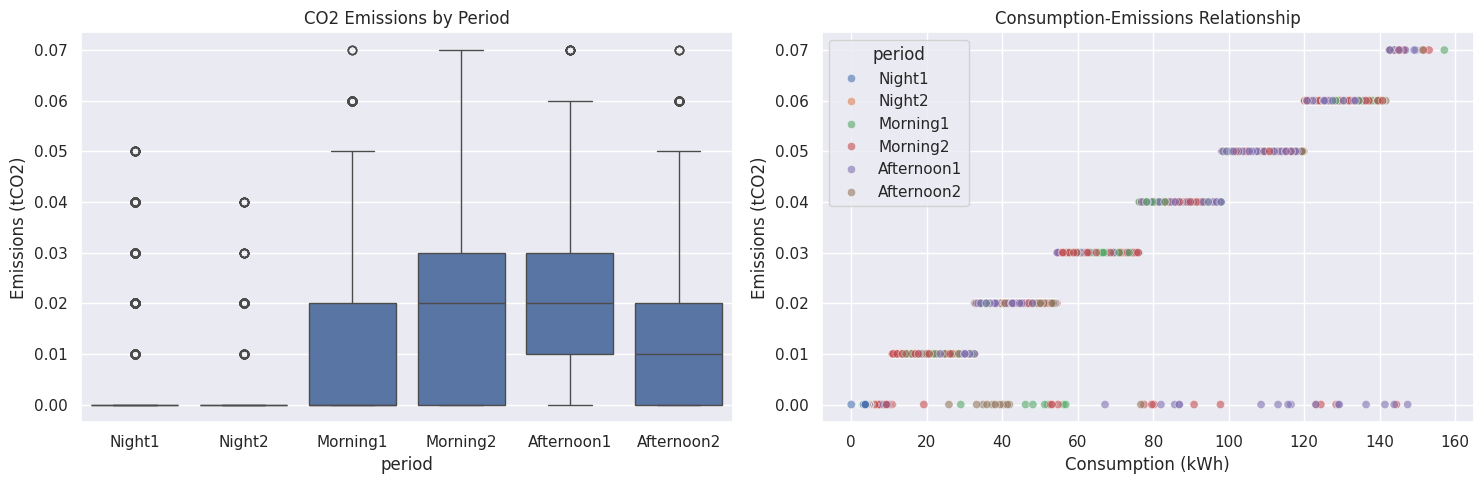

Variance explained by component:
PC1: 0.566 (0.566 cumulative)
PC2: 0.357 (0.923 cumulative)
PC3: 0.053 (0.976 cumulative)
PC4: 0.014 (0.990 cumulative)
PC5: 0.008 (0.998 cumulative)
PC6: 0.002 (1.000 cumulative)


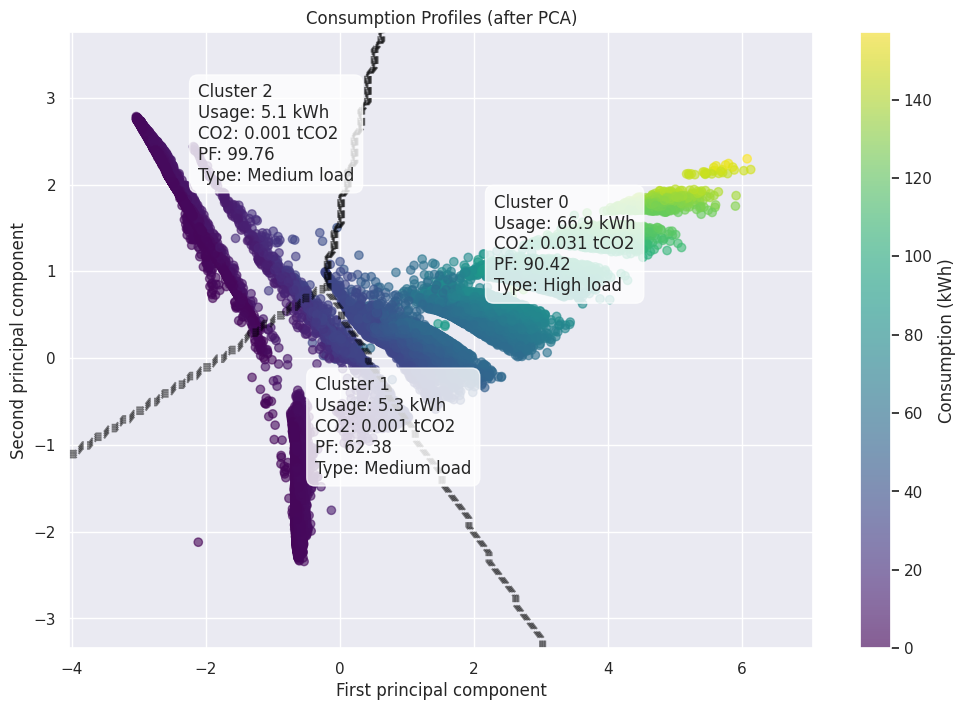


Detailed cluster analysis:

Cluster 0:
Number of points: 12590
Average consumption: 66.9 kWh
Average emissions: 0.031 tCO2
Average power factor: 90.42
Dominant period: Afternoon1

Cluster 1:
Number of points: 14836
Average consumption: 5.3 kWh
Average emissions: 0.001 tCO2
Average power factor: 62.38
Dominant period: Night2

Cluster 2:
Number of points: 7614
Average consumption: 5.1 kWh
Average emissions: 0.001 tCO2
Average power factor: 99.76
Dominant period: Afternoon2


In [4]:
# Visualization of emissions
plt.figure(figsize=(15, 5))

# Temporal distribution of emissions
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='period', y='CO2(tCO2)')
plt.title('CO2 Emissions by Period')
plt.ylabel('Emissions (tCO2)')

# Consumption-emissions relationship
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Usage_kWh', y='CO2(tCO2)',
                hue='period', alpha=0.6)
plt.title('Consumption-Emissions Relationship')
plt.xlabel('Consumption (kWh)')
plt.ylabel('Emissions (tCO2)')

plt.tight_layout()
# /!\ Complete the '...' to display the figure /!\
plt.show()

# %% [code]
# Select relevant features for environmental analysis
features = [
    'Usage_kWh',
    'CO2(tCO2)',
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor'
]

# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

# PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Display explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumsum_variance_ratio = np.cumsum(explained_variance_ratio)

print("Variance explained by component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {var:.3f} ({cumsum_variance_ratio[i]:.3f} cumulative)")

# Select the first 2 components for clustering
X_pca_2d = X_pca[:, :2]

# K-means on principal components
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_pca_2d)

# Visualization
plt.figure(figsize=(12, 8))

# Create grid for cluster boundaries
x_min, x_max = X_pca_2d[:, 0].min() - 1, X_pca_2d[:, 0].max() + 1
y_min, y_max = X_pca_2d[:, 1].min() - 1, X_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Cluster boundaries
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='black', linestyles='--', alpha=0.5)

# Scatter plot
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                     c=df['Usage_kWh'],  # Color by consumption
                     cmap='viridis',
                     alpha=0.6)

# Cluster annotations
for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    centroid = X_pca_2d[df['Cluster'] == i].mean(axis=0)

    # Cluster characteristics
    usage_mean = cluster_data['Usage_kWh'].mean()
    co2_mean = cluster_data['CO2(tCO2)'].mean()
    pf_mean = cluster_data['Lagging_Current_Power_Factor'].mean()

    # Determine profile type
    if usage_mean > df['Usage_kWh'].quantile(0.66):
        profile = "High load"
    elif usage_mean > df['Usage_kWh'].quantile(0.33):
        profile = "Medium load"
    else:
        profile = "Low load"

    plt.annotate(
        f'Cluster {i}\n'
        f'Usage: {usage_mean:.1f} kWh\n'
        f'CO2: {co2_mean:.3f} tCO2\n'
        f'PF: {pf_mean:.2f}\n'
        f'Type: {profile}',
        xy=(centroid[0], centroid[1]),
        xytext=(10, 10),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)
    )

plt.title('Consumption Profiles (after PCA)')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar(scatter, label='Consumption (kWh)')
plt.grid(True)
plt.show()

# Cluster analysis
print("\nDetailed cluster analysis:")
for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    print(f"\nCluster {i}:")
    print(f"Number of points: {len(cluster_data)}")
    print(f"Average consumption: {cluster_data['Usage_kWh'].mean():.1f} kWh")
    print(f"Average emissions: {cluster_data['CO2(tCO2)'].mean():.3f} tCO2")
    print(f"Average power factor: {cluster_data['Lagging_Current_Power_Factor'].mean():.2f}")
    print(f"Dominant period: {cluster_data['period'].value_counts().index[0]}")

❓ **Analysis Questions:**

1. **Emission Patterns**
   - Which periods show the highest emissions?
   - How can the variations in carbon emissions be explained?
   - Which factor(s) most influence these emissions?

2. **Improvement Opportunities**
   - What concrete actions can be proposed to reduce the carbon footprint?

## Cluster Analysis and Recommendations

### 1. Profile Identification

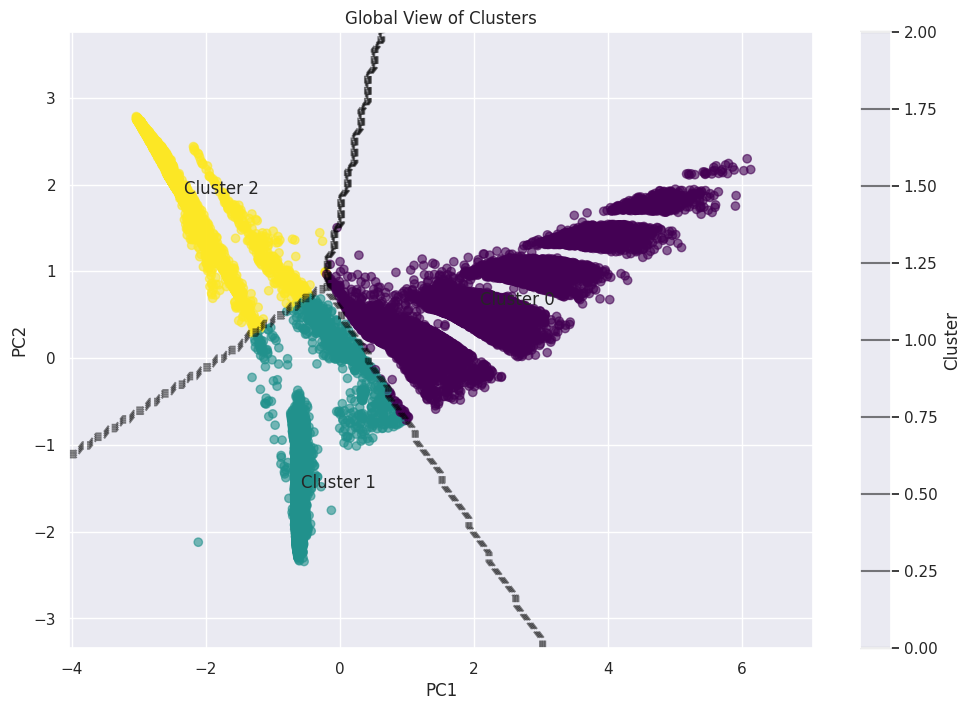

In [5]:
# Main visualization of clusters with their characteristics
plt.figure(figsize=(12, 8))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
           c=df['Cluster'], cmap='viridis',
           alpha=0.6)
plt.contour(xx, yy, Z, colors='black', linestyles='--', alpha=0.5)

for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    centroid = X_pca_2d[df['Cluster'] == i].mean(axis=0)
    plt.annotate(f'Cluster {i}', xy=(centroid[0], centroid[1]))

plt.title('Global View of Clusters')
# /!\ Complete the '...' to name the x-axis PC1 and the y-axis PC2 /!\
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

❓ **Questions about cluster separation:**
- What does the distance between points in the same cluster represent?
- How can the elongated shape of cluster 0 be explained?

### 2. Analysis of Cluster 1 - Nighttime Efficiency Issue

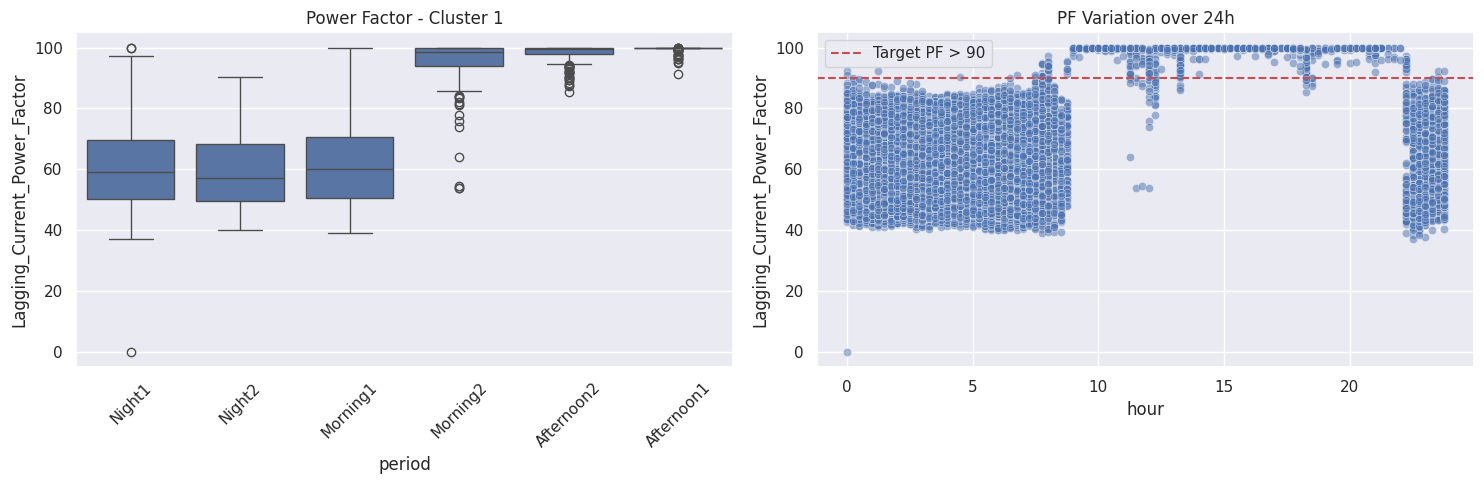

Cluster 1 statistics by period:
             count       mean        std    min     25%     50%       75%  \
period                                                                      
Afternoon1   253.0  99.749881   0.884398  91.43  99.910  99.980  100.0000   
Afternoon2   307.0  98.362801   2.546057  85.54  97.805  99.520  100.0000   
Morning1    3578.0  61.573446  12.913117  39.19  50.520  60.070   70.7100   
Morning2     265.0  95.628491   6.912018  53.69  93.930  98.470   99.9400   
Night1      4764.0  60.654731  11.839649   0.00  50.300  59.095   69.7725   
Night2      5669.0  59.163217  11.281321  40.15  49.450  57.000   68.2700   

               max  
period              
Afternoon1  100.00  
Afternoon2  100.00  
Morning1    100.00  
Morning2    100.00  
Night1      100.00  
Night2       90.22  


In [6]:
# Visualization of efficiency by period
cluster1_data = df[df['Cluster'] == 1]

plt.figure(figsize=(15, 5))

# Distribution of power factor by period
plt.subplot(1, 2, 1)
sns.boxplot(data=cluster1_data, x='period',
            y='Lagging_Current_Power_Factor')
# /!\ Complete the '...' to add the title to the figure: Power Factor - Cluster 1  /!\
plt.title("Power Factor - Cluster 1")
plt.xticks(rotation=45)

# Temporal evolution
plt.subplot(1, 2, 2)
sns.scatterplot(data=cluster1_data,
                x='hour',
                y='Lagging_Current_Power_Factor',
                alpha=0.5)
plt.axhline(y=90, color='r', linestyle='--',
            label='Target PF > 90')
plt.title('PF Variation over 24h')
plt.legend()
plt.tight_layout()
plt.show()

print("Cluster 1 statistics by period:")
print(cluster1_data.groupby('period')['Lagging_Current_Power_Factor'].describe())

❓ **Questions about nighttime inefficiency:**
- Why is the power factor lower at night?
- What would be the financial impact of improving nighttime power factor?

### 3. Analysis of Cluster 0 - Peak Load Management

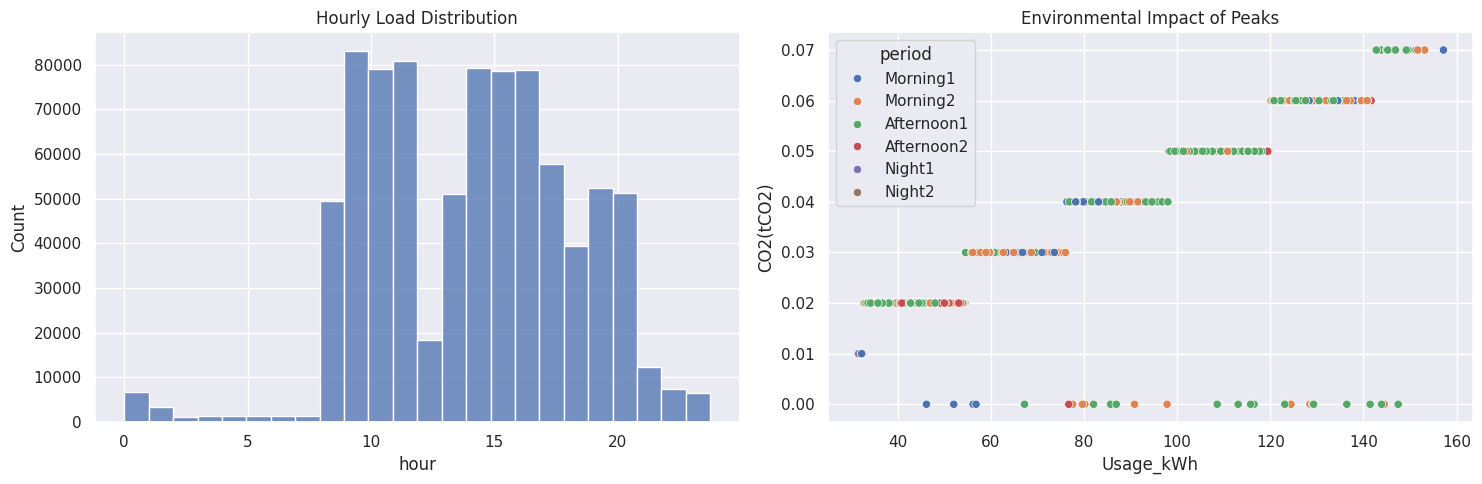


Analysis of peaks by period:
                 mean  count
period                      
Afternoon1  69.269565   4249
Morning2    68.913761   3321
Morning1    68.321719   1978
Afternoon2  61.693536   2520
Night1      58.006959    411
Night2      45.874414    111


In [7]:
# Analysis of consumption peaks
# /!\ Complete the '...' to assign to the variable cluster0_data the dataframe where only cluster 0 is selected /!\
cluster0_data = df[df['Cluster'] == 0]

plt.figure(figsize=(15, 5))

# Hourly distribution of load
plt.subplot(1, 2, 1)
sns.histplot(data=cluster0_data, x='hour',
             weights='Usage_kWh', bins=24)
plt.title('Hourly Load Distribution')

# Load-emissions relationship
plt.subplot(1, 2, 2)
sns.scatterplot(data=cluster0_data,
                x='Usage_kWh',
                y='CO2(tCO2)',
                hue='period')
plt.title('Environmental Impact of Peaks')
plt.tight_layout()
plt.show()

# Analysis of peak periods
peak_periods = cluster0_data.groupby('period')['Usage_kWh'].agg(['mean', 'count'])
print("\nAnalysis of peaks by period:")
print(peak_periods.sort_values('mean', ascending=False))

❓ **Questions about peak loads:**
- Why are peaks concentrated in certain periods?
- What is the trade-off between load smoothing and production constraints?

### 4. Analysis of Cluster 2 - Efficiency Model

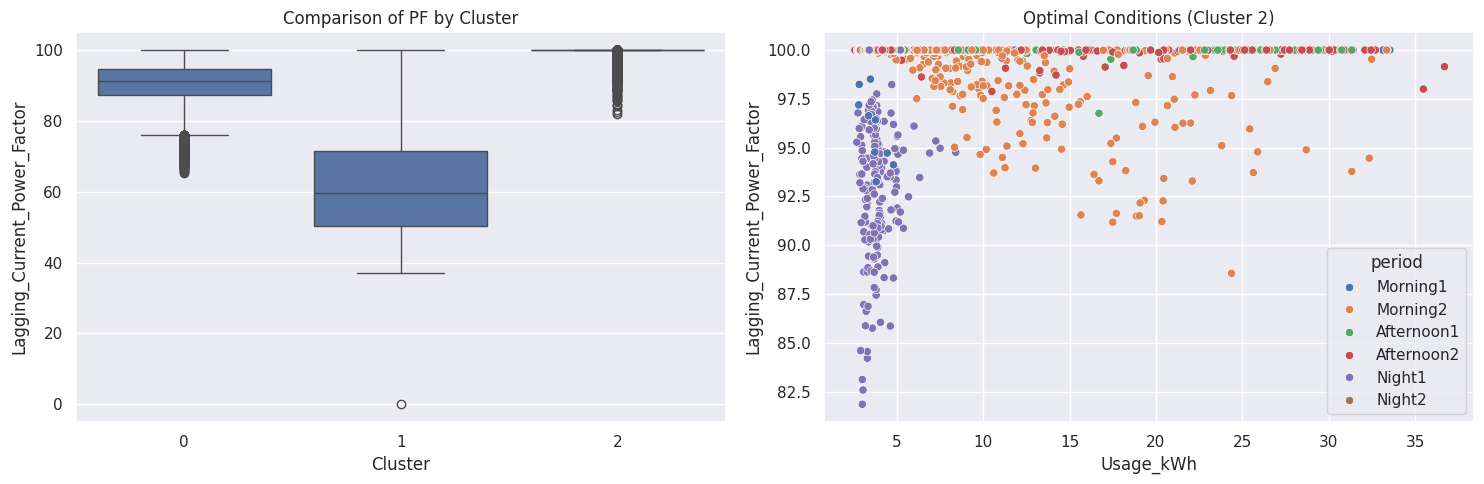


Optimal operating conditions:
            Usage_kWh  Lagging_Current_Power_Factor
period                                             
Afternoon1       5.13                        100.00
Afternoon2       4.81                         99.99
Morning1         4.96                         99.95
Morning2         5.65                         99.90
Night1           3.78                         99.63
Night2           3.05                        100.00


In [8]:
# Comparison of operational conditions
cluster2_data = df[df['Cluster'] == 2]

plt.figure(figsize=(15, 5))

# Comparison of power factors
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Cluster',
            y='Lagging_Current_Power_Factor')
plt.title('Comparison of PF by Cluster')

# Analysis of optimal conditions
plt.subplot(1, 2, 2)
sns.scatterplot(data=cluster2_data,
                x='Usage_kWh',
                y='Lagging_Current_Power_Factor',
                hue='period')
plt.title('Optimal Conditions (Cluster 2)')
plt.tight_layout()
plt.show()

# Identification of best practices
best_conditions = cluster2_data[cluster2_data['Lagging_Current_Power_Factor'] > 95]
print("\nOptimal operating conditions:")
print(best_conditions.groupby('period').agg({
    'Usage_kWh': 'mean',
    'Lagging_Current_Power_Factor': 'mean'
}).round(2))

❓ **Questions about best practices:**
- What specific conditions allow for a PF > 95?
- How can these conditions be generalized to other periods?
- What would be the financial consequence of implementing these improvements?

### 5. Implementation and Monitoring Plan

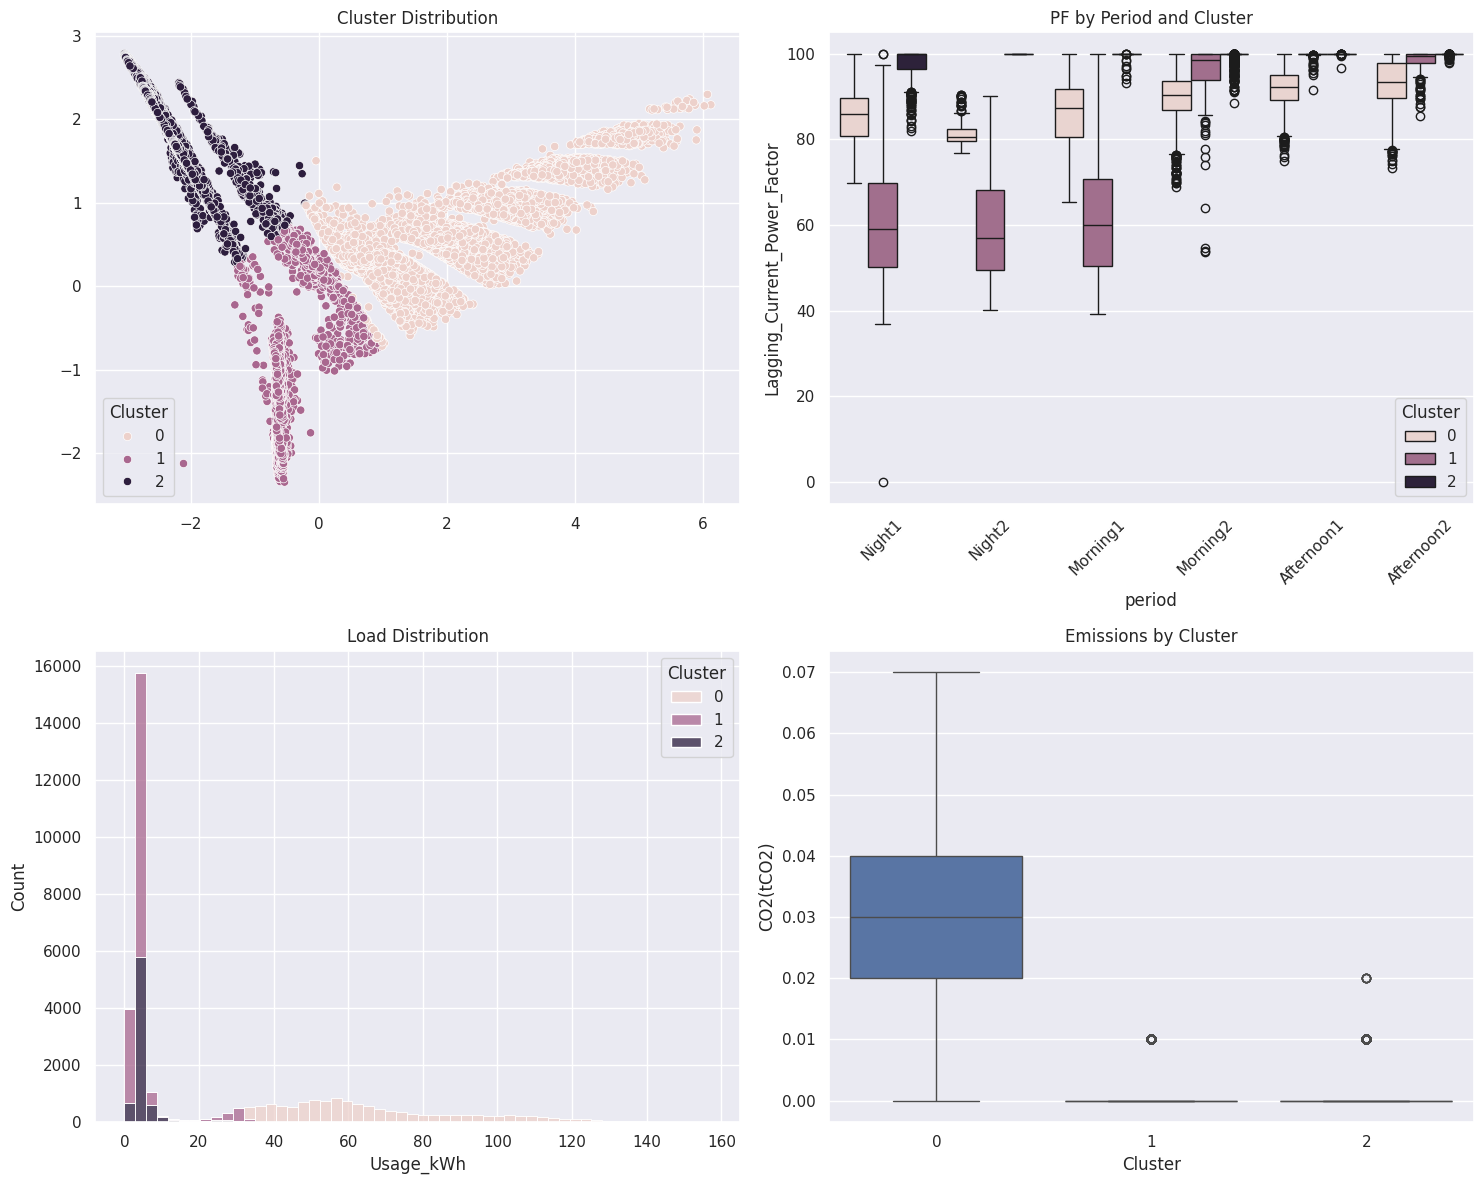


Base KPIs:

Cluster 0:
Average PF: 90.42
% points PF > 90: 58.4%
Average emissions: 0.031 tCO2

Cluster 1:
Average PF: 62.38
% points PF > 90: 6.0%
Average emissions: 0.001 tCO2

Cluster 2:
Average PF: 99.76
% points PF > 90: 99.6%
Average emissions: 0.001 tCO2


In [9]:
# Creation of a monitoring dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Cluster distribution
sns.scatterplot(data=df, x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
                hue='Cluster', ax=axes[0, 0])
axes[0, 0].set_title('Cluster Distribution')

# 2. PF evolution
sns.boxplot(data=df, x='period', y='Lagging_Current_Power_Factor',
            hue='Cluster', ax=axes[0, 1])
axes[0, 1].set_title('PF by Period and Cluster')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Load distribution
sns.histplot(data=df, x='Usage_kWh', hue='Cluster',
             multiple="stack", ax=axes[1, 0])
axes[1, 0].set_title('Load Distribution')

# 4. Emissions by cluster
sns.boxplot(data=df, x='Cluster', y='CO2(tCO2)', ax=axes[1, 1])
axes[1, 1].set_title('Emissions by Cluster')

plt.tight_layout()
plt.show()

# Current KPIs
print("\nBase KPIs:")
for cluster in range(3):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Average PF: {cluster_data['Lagging_Current_Power_Factor'].mean():.2f}")
    print(f"% points PF > 90: {(cluster_data['Lagging_Current_Power_Factor'] > 90).mean()*100:.1f}%")
    print(f"Average emissions: {cluster_data['CO2(tCO2)'].mean():.3f} tCO2")

❓ **Questions about monitoring:**
- What additional KPIs would be relevant?
- How can performance drift be detected?

## Recommendations for Emission Reduction

1. **Operational Optimization**
   - Identify and replicate conditions of low-intensity periods
   - Optimize scheduling of energy-intensive operations
   - Train teams in best environmental practices

2. **Technical Improvements**
   - Modernize the most polluting equipment
   - Install real-time emission monitoring systems
   - Implement energy recovery systems

3. **Long-term Strategy**
   - Set reduction targets by cluster
   - Invest in low-carbon technologies
   - Develop an energy transition plan

❓ **Questions about implementation:**
- Where to concretely start?
- How to involve teams in these changes?